In [1]:
# === Motor Insurance — Full Project (Cleaning → EDA → PCA/Clustering → M1/M2/M3 → CV → Predict) ===
# Files expected next to the notebook:
#   - claims_train.csv
#   - claims_test.csv

TRAIN_PATH = "claims_train.csv"
TEST_PATH  = "claims_test.csv"

ID_COL = "IDpol"
NUMERIC_COLS = ["ClaimNb","Exposure","VehPower","VehAge","DrivAge","BonusMalus","Density"]
CATEGORICAL_COLS = ["Area","VehBrand","VehGas","Region"]
FEATURES = ["Area","VehBrand","VehGas","Region","VehPower","VehAge","DrivAge","BonusMalus","Density"]


In [2]:
import os, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, issparse

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import mean_absolute_error, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)


In [3]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

def basic_checks(df: pd.DataFrame, name="df"):
    print(f"--- {name} ---")
    print("shape:", df.shape)
    miss = (df.isna().sum() / len(df) * 100).round(3)
    print("missing % per col:\n", miss.sort_values(ascending=False))
    print("Exposure <= 0:", int((df["Exposure"] <= 0).sum()))
    if "ClaimNb" in df.columns:
        non_int = (~np.isfinite(df["ClaimNb"])) | (df["ClaimNb"] != np.floor(df["ClaimNb"]))
        print("ClaimNb not integer:", int(non_int.sum()))
        print("ClaimNb < 0:", int((df["ClaimNb"] < 0).sum()))
    print("Duplicates (full row):", int(df.duplicated().sum()))
    if ID_COL in df.columns:
        print("Duplicate IDpol:", int(df[ID_COL].duplicated().sum()))
    print()

basic_checks(train, "train (raw)")
basic_checks(test, "test  (raw)")
train.head()


--- train (raw) ---
shape: (542410, 12)
missing % per col:
 IDpol         0.0
ClaimNb       0.0
Exposure      0.0
Area          0.0
VehPower      0.0
VehAge        0.0
DrivAge       0.0
BonusMalus    0.0
VehBrand      0.0
VehGas        0.0
Density       0.0
Region        0.0
dtype: float64
Exposure <= 0: 0
ClaimNb not integer: 0
ClaimNb < 0: 0
Duplicates (full row): 0
Duplicate IDpol: 0

--- test  (raw) ---
shape: (135603, 12)
missing % per col:
 IDpol         0.0
ClaimNb       0.0
Exposure      0.0
Area          0.0
VehPower      0.0
VehAge        0.0
DrivAge       0.0
BonusMalus    0.0
VehBrand      0.0
VehGas        0.0
Density       0.0
Region        0.0
dtype: float64
Exposure <= 0: 0
ClaimNb not integer: 0
ClaimNb < 0: 0
Duplicates (full row): 0
Duplicate IDpol: 0



,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
1,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
2,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
3,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
4,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [4]:
# Expected ranges (tuned for motor insurance; adjust if needed)
RANGES = {
    "Exposure":   {"min": 0, "max_warn": 2.0},      # >1 flagged; <=0 invalid
    "ClaimNb":    {"min": 0, "integer": True},
    "DrivAge":    {"min": 16, "max": 100},
    "VehAge":     {"min": 0, "max": 60},
    "VehPower":   {"min": 1, "max": 400},
    "BonusMalus": {"min": 0, "max": 350},
    "Density":    {"min": 1, "max_warn": 50000},
}

def range_violations(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col, spec in RANGES.items():
        if col not in df.columns: 
            continue
        s = df[col]
        if "integer" in spec and spec["integer"]:
            nonint = (~np.isfinite(s)) | (s != np.floor(s))
            rows.append({"column": col, "check": "not_integer", "violations": int(nonint.sum())})
        if "min" in spec:
            rows.append({"column": col, "check": f"<{spec['min']}", "violations": int((s < spec["min"]).sum())})
        if "max" in spec:
            rows.append({"column": col, "check": f">{spec['max']}", "violations": int((s > spec["max"]).sum())})
        if "max_warn" in spec:
            rows.append({"column": col, "check": f">{spec['max_warn']} (warn)", "violations": int((s > spec["max_warn"]).sum())})
    return pd.DataFrame(rows).sort_values(["violations","column"], ascending=[False,True])

viol_train = range_violations(train)
viol_test  = range_violations(test)
print("=== Range & integrity violations — TRAIN ===")
display(viol_train)
print("=== Range & integrity violations — TEST ===")
display(viol_test)

def clean(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d = d[d["Exposure"] > 0].copy()                   # drop impossible exposure
    d["over1"] = (d["Exposure"] > 1).astype(int)      # keep flag for analysis
    for c in CATEGORICAL_COLS:
        if c in d.columns:
            d[c] = d[c].astype("category")
    return d

train_c = clean(train)
test_c  = clean(test)
print("Rows with Exposure>1 in train:", int((train_c["Exposure"] > 1).sum()))


=== Range & integrity violations — TRAIN ===


,column,check,violations
7,VehAge,>60,61
1,Exposure,>2.0 (warn),2
10,BonusMalus,<0,0
11,BonusMalus,>350,0
2,ClaimNb,not_integer,0
3,ClaimNb,<0,0
12,Density,<1,0
13,Density,>50000 (warn),0
4,DrivAge,<16,0
5,DrivAge,>100,0


=== Range & integrity violations — TEST ===


,column,check,violations
7,VehAge,>60,18
10,BonusMalus,<0,0
11,BonusMalus,>350,0
2,ClaimNb,not_integer,0
3,ClaimNb,<0,0
12,Density,<1,0
13,Density,>50000 (warn),0
4,DrivAge,<16,0
5,DrivAge,>100,0
0,Exposure,<0,0


Rows with Exposure>1 in train: 994


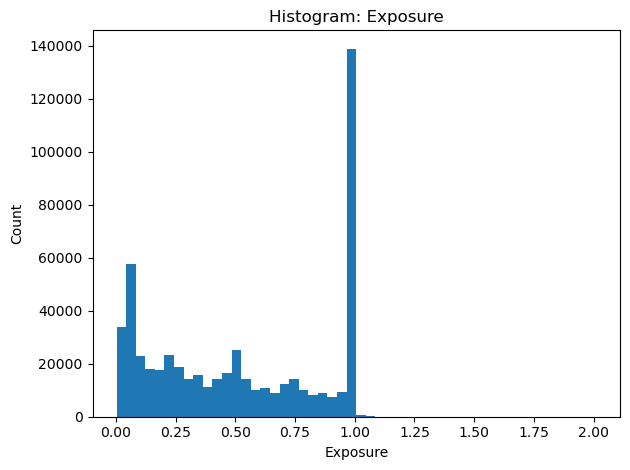

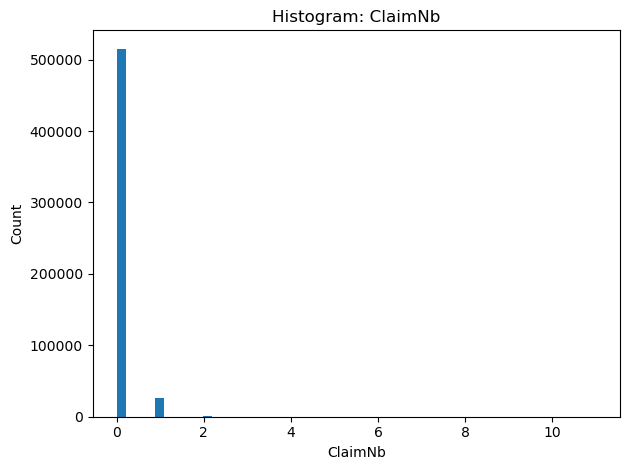

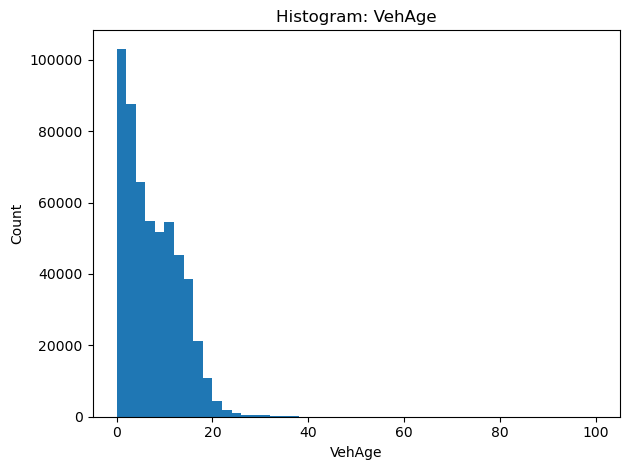

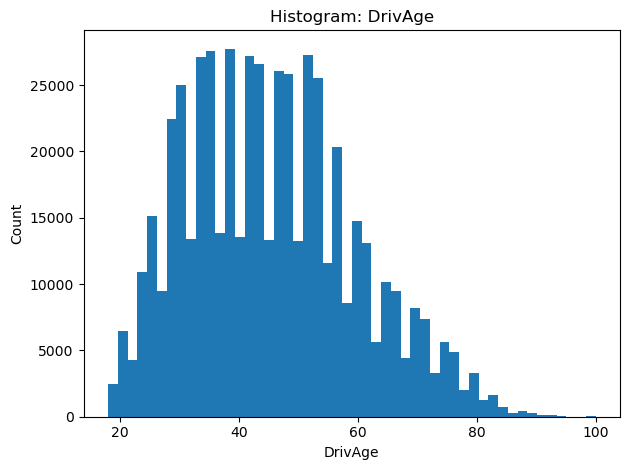

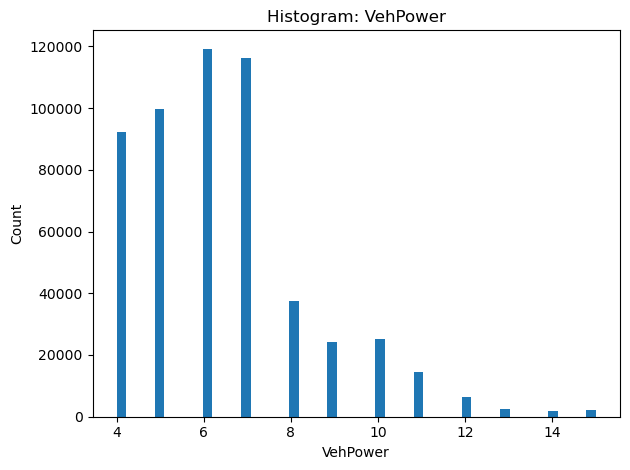

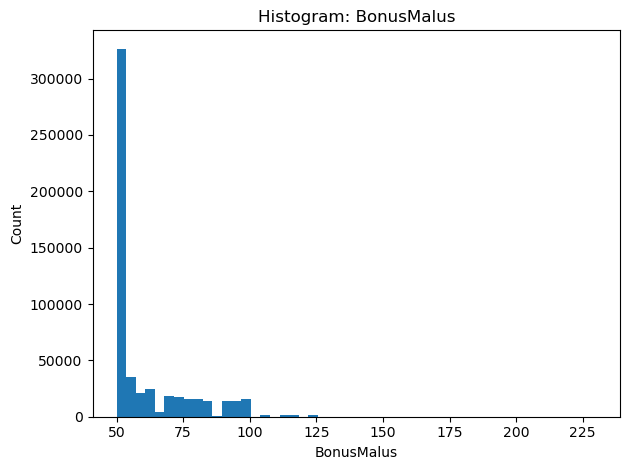

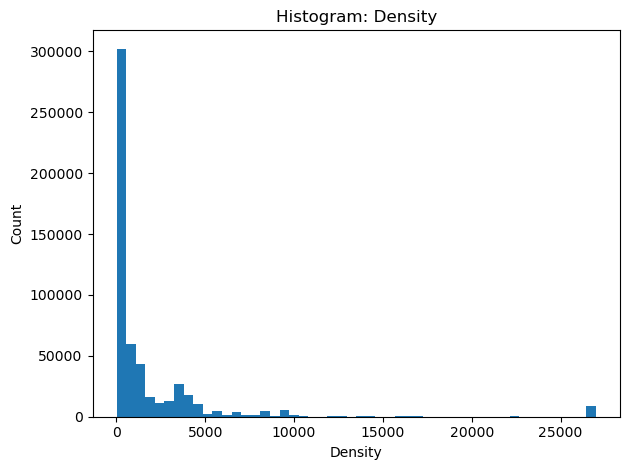

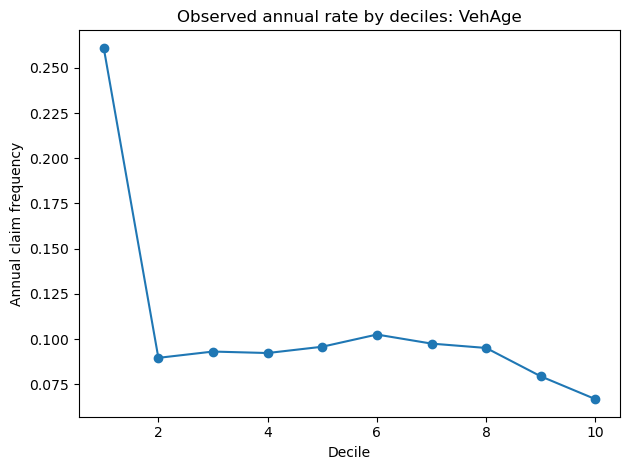

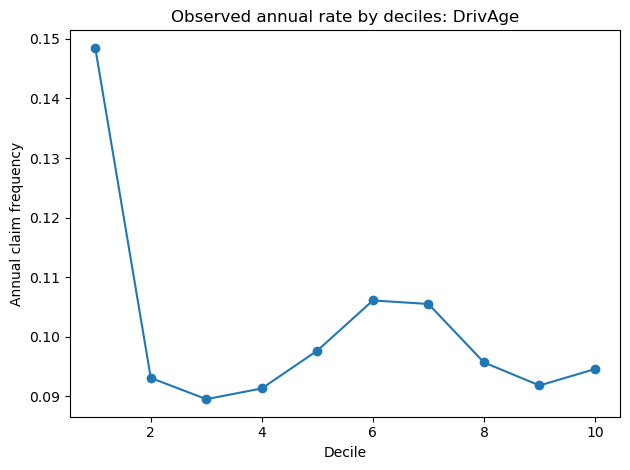

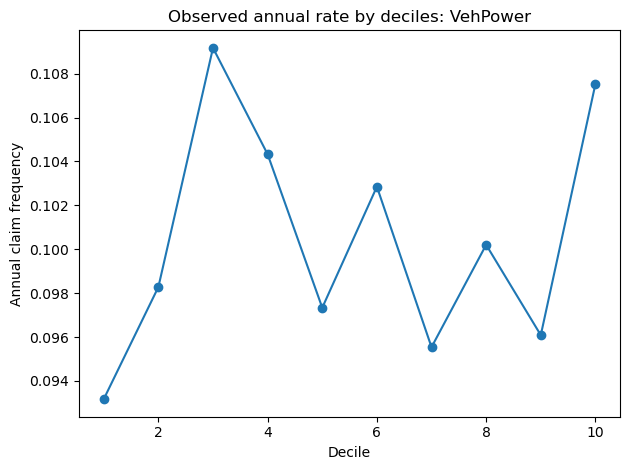

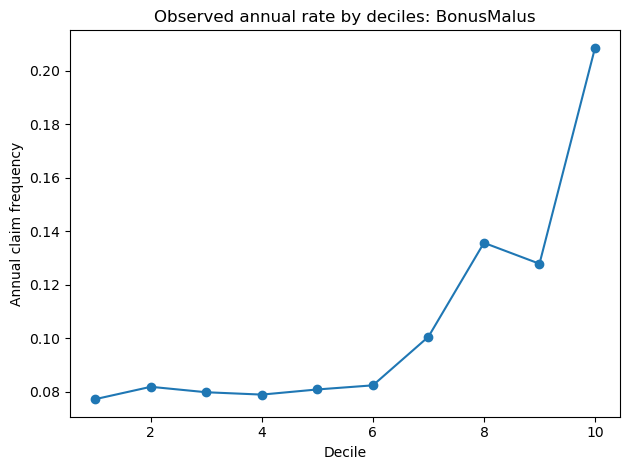

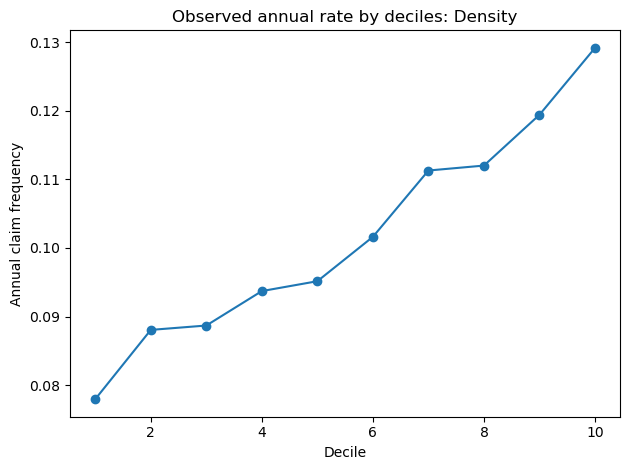

,Area,rate
5,F,0.142407
4,E,0.121192
3,D,0.108526
2,C,0.094659
1,B,0.088505
0,A,0.081516


,VehBrand,rate
3,B12,0.136009
2,B11,0.106179
9,B5,0.101285
7,B3,0.097864
4,B13,0.097298
8,B4,0.095827
10,B6,0.092741
0,B1,0.090559
1,B10,0.090363
6,B2,0.090119


,VehGas,rate
1,Regular,0.103486
0,Diesel,0.097109


,Region,rate
0,R11,0.131869
17,R82,0.111423
20,R93,0.108261
19,R91,0.105355
7,R31,0.102849
6,R26,0.099117
3,R23,0.097690
14,R72,0.096411
12,R53,0.096006
15,R73,0.095940


In [5]:
# Histograms for key numerics
for col in ["Exposure","ClaimNb","VehAge","DrivAge","VehPower","BonusMalus","Density"]:
    if col in train_c.columns:
        plt.figure()
        train_c[col].dropna().plot(kind="hist", bins=50)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout(); plt.show()

# Observed annual rate by numeric deciles
def obs_rate(g): 
    return g["ClaimNb"].sum() / g["Exposure"].sum() if g["Exposure"].sum()>0 else np.nan

work = train_c.copy()
for col in ["VehAge","DrivAge","VehPower","BonusMalus","Density"]:
    if col in work.columns:
        try:
            work[f"{col}_bin"] = pd.qcut(work[col].rank(method="first"), 10, duplicates="drop")
            g = work.groupby(f"{col}_bin").apply(obs_rate).reset_index(name="rate")
            plt.figure()
            plt.plot(range(1, len(g)+1), g["rate"], marker="o")
            plt.title(f"Observed annual rate by deciles: {col}")
            plt.xlabel("Decile"); plt.ylabel("Annual claim frequency")
            plt.tight_layout(); plt.show()
        except Exception as e:
            print("Skip", col, "->", e)

# Observed rate by top categorical levels
for col in ["Area","VehBrand","VehGas","Region"]:
    if col in work.columns:
        top = work[col].value_counts().head(15).index
        g = work[work[col].isin(top)].groupby(col).apply(obs_rate).reset_index(name="rate").sort_values("rate", ascending=False)
        display(g)


Explained variance PC1/PC2 (%): [19.03 15.29]


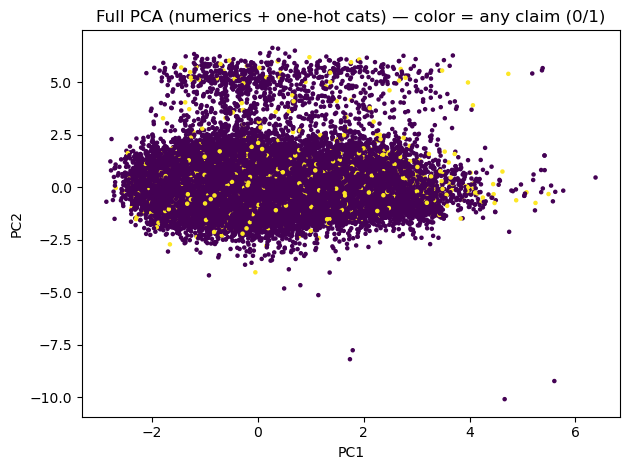

,k,silhouette,calinski,dbi
1,4,0.360518,370072.595252,0.857871
2,5,0.335543,360105.803956,0.877442
0,3,0.334533,315048.292352,0.980360
5,8,0.331210,365006.233928,0.823000
3,6,0.324218,352908.314546,0.943574
6,9,0.321550,351608.440642,0.872304
7,10,0.316360,346926.464451,0.889881
4,7,0.314826,358847.269974,0.893887
8,12,0.313254,336854.114345,0.901959
10,20,0.309151,323908.620569,0.854880


Chosen K: 4  (sil=0.361, CH=370073, DBI=0.858)


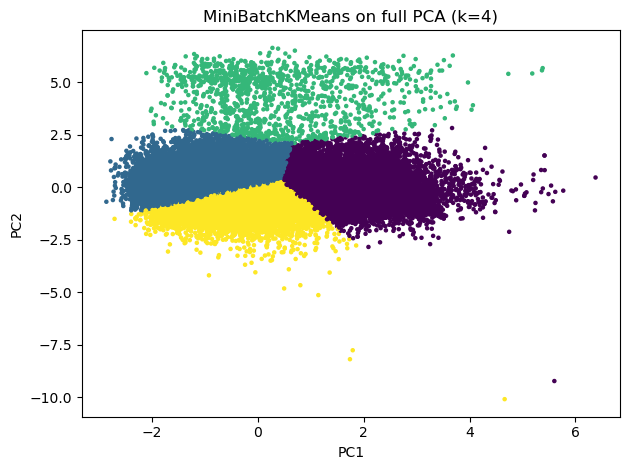

,cluster,n,Exposure_sum,obs_freq
2,2,13902.0,6159.312597,0.152939
0,0,128477.0,53818.821551,0.145618
1,1,216693.0,110170.909483,0.104728
3,3,183338.0,116698.936974,0.072811


In [6]:
# === Full PCA on all features (one-hot cats + scaled numerics) with IncrementalPCA (batching) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack, issparse, csr_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# ---- Config (tune for your machine) ----
BATCH_SIZE_IPCA = 12000     # batch for IncrementalPCA partial_fit/transform
BATCH_SIZE_KMEANS = 16384   # batch for MiniBatchKMeans
PLOT_SAMPLE = 50000        # points to plot
SIL_SAMPLE  = 20000        # points for silhouette
K_CANDIDATES = [3,4,5,6,7,8,9,10,12,15,20]  # k to try

# ---- Feature sets ----
NUM_PCA_COLS = ["VehPower","VehAge","DrivAge","BonusMalus","Density"]
CAT_COLS = CATEGORICAL_COLS

# (Optional) group rare levels to keep one-hot width reasonable
def group_rare_levels(df, col, min_count=2000, other_label="_OTHER"):
    vc = df[col].value_counts()
    rare = vc[vc < min_count].index
    if len(rare):
        df[col] = df[col].astype(str)
        df.loc[df[col].isin(rare), col] = other_label
        df[col] = df[col].astype("category")

for col in ["VehBrand","Region"]:
    group_rare_levels(train_c, col, min_count=2000)
    group_rare_levels(test_c,  col, min_count=2000)

# ---- Fit encoders on TRAIN ----
# One-hot (sparse) for categoricals; StandardScaler for numerics
def make_onehot_sparse():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

onehot = make_onehot_sparse()
# Fill missing cat as string token before fitting
cats_train = train_c[CAT_COLS].astype(str).fillna("_MISSING_")
onehot.fit(cats_train)

# Scale numerics (fit on full train numerics)
num_train = train_c[NUM_PCA_COLS].copy()
num_train = num_train.fillna(num_train.median(numeric_only=True))
num_scaler = StandardScaler()
num_scaler.fit(num_train)

# ---- Helper to build a dense batch for PCA ----
def build_dense_batch(df, start, stop):
    # Categoricals -> sparse one-hot
    X_cat = onehot.transform(df.iloc[start:stop][CAT_COLS].astype(str).fillna("_MISSING_"))
    # Numerics -> scaled dense
    X_num = df.iloc[start:stop][NUM_PCA_COLS].copy()
    X_num = X_num.fillna(num_train.median(numeric_only=True))
    X_num = num_scaler.transform(X_num)
    # Stack: [num | one-hot] -> sparse then densify this batch only
    # (order doesn't matter for PCA; we keep nums first for readability)
    X_sparse = hstack([csr_matrix(X_num), X_cat], format="csr")
    X_dense  = X_sparse.toarray().astype("float32")
    return X_dense

N = len(train_c)
ipca = IncrementalPCA(n_components=2)  # 2D for viz/clustering; true PCA with centering

# ---- Pass 1: partial_fit on batches ----
for start in range(0, N, BATCH_SIZE_IPCA):
    stop = min(start + BATCH_SIZE_IPCA, N)
    X_batch = build_dense_batch(train_c, start, stop)
    ipca.partial_fit(X_batch)

# ---- Pass 2: transform all rows in batches ----
X_pca = np.empty((N, 2), dtype="float32")
for start in range(0, N, BATCH_SIZE_IPCA):
    stop = min(start + BATCH_SIZE_IPCA, N)
    X_batch = build_dense_batch(train_c, start, stop)
    X_pca[start:stop] = ipca.transform(X_batch)

expl_var = ipca.explained_variance_ratio_
print("Explained variance PC1/PC2 (%):", (expl_var * 100).round(2))

# ---- Visualize PCA (sampled) ----
rng = np.random.RandomState(0)
idx_plot = rng.choice(N, size=min(PLOT_SAMPLE, N), replace=False)
had_claim = (train_c["ClaimNb"] > 0).astype(int).values

plt.figure()
plt.scatter(X_pca[idx_plot,0], X_pca[idx_plot,1], c=had_claim[idx_plot], s=5)
plt.title("Full PCA (numerics + one-hot cats) — color = any claim (0/1)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# ---- Fast clustering in PCA(2D) ----
results = []
idx_sil = rng.choice(N, size=min(SIL_SAMPLE, N), replace=False)
for k in K_CANDIDATES:
    km = MiniBatchKMeans(n_clusters=k, batch_size=BATCH_SIZE_KMEANS, n_init=10, random_state=0)
    labels = km.fit_predict(X_pca)  # very fast in 2D
    sil = silhouette_score(X_pca[idx_sil], labels[idx_sil])
    ch  = calinski_harabasz_score(X_pca, labels)
    dbi = davies_bouldin_score(X_pca, labels)
    results.append({"k": k, "silhouette": sil, "calinski": ch, "dbi": dbi, "labels": labels})

res_df = pd.DataFrame([{k:v for k,v in r.items() if k!="labels"} for r in results])
display(res_df.sort_values(["silhouette","calinski","dbi"], ascending=[False,False,True]))

best = max(results, key=lambda r: (r["silhouette"], r["calinski"], -r["dbi"]))
best_k, best_labels = best["k"], best["labels"]
print(f"Chosen K: {best_k}  (sil={best['silhouette']:.3f}, CH={best['calinski']:.0f}, DBI={best['dbi']:.3f})")

plt.figure()
plt.scatter(X_pca[idx_plot,0], X_pca[idx_plot,1], c=best_labels[idx_plot], s=5)
plt.title(f"MiniBatchKMeans on full PCA (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# ---- Cluster profiling (exposure-weighted frequency) ----
prof = pd.DataFrame({
    "cluster": best_labels,
    "Exposure": train_c["Exposure"].values,
    "ClaimNb": train_c["ClaimNb"].values
}).groupby("cluster").apply(lambda g: pd.Series({
    "n": len(g),
    "Exposure_sum": g["Exposure"].sum(),
    "obs_freq": g["ClaimNb"].sum() / g["Exposure"].sum()
})).reset_index().sort_values("obs_freq", ascending=False)
display(prof)


In [7]:
# Helper defined here so this cell works even if Cell 6 wasn't run:
def make_onehot_dense():
    """Version-safe dense OneHotEncoder."""
    try:
        # sklearn >= 1.2
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # sklearn < 1.2
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

train_c["y_rate"] = train_c["ClaimNb"] / train_c["Exposure"]
train_c["w"] = train_c["Exposure"]
X = train_c[FEATURES].copy()
y_rate = train_c["y_rate"].values
w = train_c["w"].values

onehot = make_onehot_dense()
scale  = StandardScaler()

# Tree: scaling not needed for numerics; one-hot is fine
pre_tree = ColumnTransformer([
    ("cat", onehot, CATEGORICAL_COLS),
    ("num", "passthrough", ["VehPower","VehAge","DrivAge","BonusMalus","Density"])
])

# MLP: scale numerics; keep dense one-hot for the neural net
pre_scaled = ColumnTransformer([
    ("cat", onehot, CATEGORICAL_COLS),
    ("num", scale,      ["VehPower","VehAge","DrivAge","BonusMalus","Density"])
])


In [8]:
def w_poisson_deviance(y_true_count, mu_count, w_exposure=None, eps=1e-12):
    y = np.asarray(y_true_count, dtype=float)
    mu = np.asarray(mu_count, dtype=float).clip(min=eps)
    if w_exposure is None:
        w_exposure = np.ones_like(y)
    term = np.where(y > 0, y * np.log((y + eps) / mu) - (y - mu), - (y - mu))
    dev = 2.0 * term
    return np.sum(dev * w_exposure) / np.sum(w_exposure)

def smape(y_true, y_pred, w_exposure=None, eps=1e-12):
    y = np.asarray(y_true, dtype=float)
    p = np.asarray(y_pred, dtype=float)
    sm = np.abs(p - y) / np.maximum((np.abs(y) + np.abs(p))/2.0, eps)
    return np.average(sm, weights=w_exposure) if w_exposure is not None else np.mean(sm)

def top_decile_lift(y_true_count, pred_rate, exposure, frac=0.1):
    n = len(pred_rate); cutoff = max(1, int(math.ceil(frac * n)))
    order = np.argsort(-pred_rate)[:cutoff]
    rate_top = y_true_count[order].sum() / exposure[order].sum()
    rate_all = y_true_count.sum() / exposure.sum()
    return float(rate_top / rate_all) if rate_all > 0 else np.nan

def decile_calibration_table(y_true_count, pred_rate, exposure, n_bins=10):
    df = pd.DataFrame({"y": y_true_count, "rate_pred": pred_rate, "exp": exposure})
    df["decile"] = pd.qcut(df["rate_pred"].rank(method="first"), n_bins, labels=False) + 1
    cal = df.groupby("decile").apply(
        lambda g: pd.Series({
            "n": len(g),
            "Exposure_sum": g["exp"].sum(),
            "obs_freq": g["y"].sum() / g["exp"].sum(),
            "pred_freq_mean": g["rate_pred"].mean()
        })
    ).reset_index()
    return cal

def plot_calibration(cal, title):
    plt.figure()
    plt.plot(cal["decile"], cal["obs_freq"], marker="o", label="Observed")
    plt.plot(cal["decile"], cal["pred_freq_mean"], marker="o", label="Predicted")
    plt.xlabel("Decile (predicted risk ↑)"); plt.ylabel("Annual claim frequency")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def cv_evaluate_rate_model(make_pipeline, X, y_rate, w_exp, k=5, name="model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    oof_pred_rate = np.zeros(len(y_rate), dtype=float)
    rows = []
    for fold, (tr, va) in enumerate(kf.split(X), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y_rate[tr], y_rate[va]
        wtr, wva = w_exp[tr], w_exp[va]
        pipe = make_pipeline()
        try:
            pipe.fit(Xtr, ytr, **{"model__sample_weight": wtr})
        except TypeError:
            pipe.fit(Xtr, ytr)
        p_rate = pipe.predict(Xva).clip(min=1e-8)
        oof_pred_rate[va] = p_rate

        yva_count = yva * wva
        mu_count  = p_rate * wva
        rows.append({
            "fold": fold,
            "poisson_dev": w_poisson_deviance(yva_count, mu_count, wva),
            "wMAE_rate": mean_absolute_error(yva, p_rate, sample_weight=wva),
            "sMAPE_rate": smape(yva, p_rate, wva),
            "top10_lift": top_decile_lift(yva_count, p_rate, wva)
        })
    res = pd.DataFrame(rows); display(res)
    print("Mean metrics:", res.mean(numeric_only=True).to_dict())
    cal = decile_calibration_table(y_rate*w_exp, oof_pred_rate, w_exp)
    plot_calibration(cal, f"Calibration — {name} (OOF)")
    return res.mean(numeric_only=True).to_dict(), oof_pred_rate, cal


,fold,poisson_dev,wMAE_rate,sMAPE_rate,top10_lift
0,1,0.349451,0.183420,1.977792,3.573906
1,2,0.346134,0.182626,1.978142,3.621755
2,3,0.347770,0.182982,1.977851,3.572755


Mean metrics: {'fold': 2.0, 'poisson_dev': 0.34778520382981015, 'wMAE_rate': 0.18300925313699576, 'sMAPE_rate': 1.977928255294066, 'top10_lift': 3.5894722443233853}


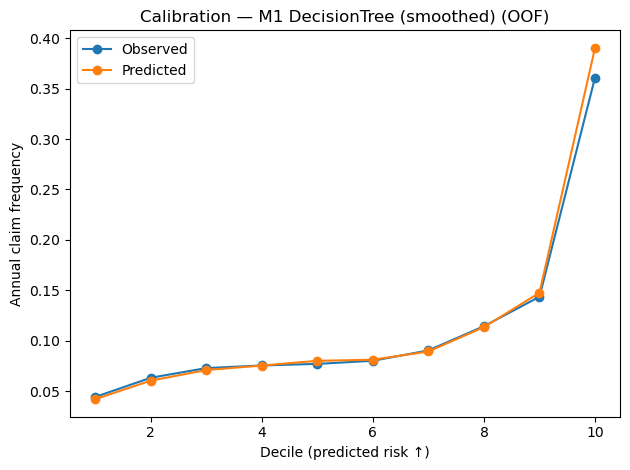

In [9]:
def make_m1():
    tree = DecisionTreeRegressor(
        max_depth=7,
        min_samples_leaf=1500,   # larger leaf -> smoother, better calibrated
        min_samples_split=3000,
        random_state=0
    )
    return Pipeline([("pre", pre_tree), ("model", tree)])

m1_summary, m1_oof, m1_cal = cv_evaluate_rate_model(
    make_m1, X, y_rate, w, k=3, name="M1 DecisionTree (smoothed)"
)


,fold,poisson_dev,wMAE_rate,sMAPE_rate,top10_lift
0,1,0.359332,0.182028,1.979126,3.172562
1,2,0.350412,0.175998,1.979005,3.280619
2,3,0.353226,0.185744,1.977605,3.109667
3,4,0.350094,0.189690,1.977301,3.276926
4,5,0.357035,0.187802,1.977163,3.204293


Mean metrics: {'fold': 3.0, 'poisson_dev': 0.35401973624035843, 'wMAE_rate': 0.184252241328665, 'sMAPE_rate': 1.9780400269206702, 'top10_lift': 3.208813371920693}


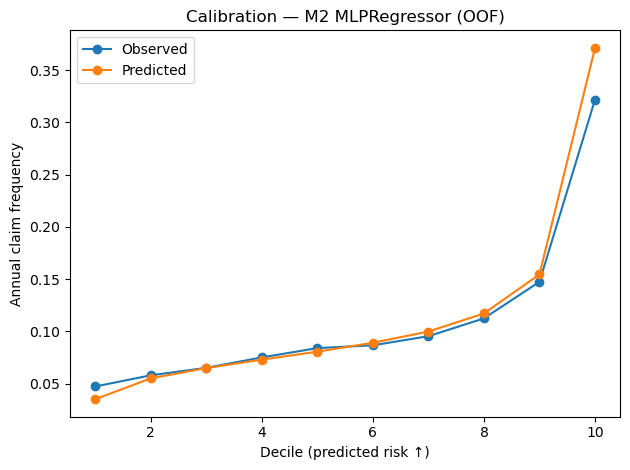

In [10]:
def make_m2():
    mlp = MLPRegressor(hidden_layer_sizes=(64,32), activation="relu", solver="adam",
                       alpha=1e-4, batch_size=256, learning_rate_init=1e-3,
                       max_iter=200, early_stopping=True, random_state=0)
    return Pipeline([("pre", pre_scaled), ("model", mlp)])

m2_summary, m2_oof, m2_cal = cv_evaluate_rate_model(make_m2, X, y_rate, w, k=5, name="M2 MLPRegressor")


,fold,family,overdispersion,poisson_dev,wMAE_rate,sMAPE_rate,top10_lift
0,1,NegBin,2.613487,0.357456,0.188461,1.979875,2.215083
1,2,NegBin,2.640374,0.355870,0.188142,1.980104,2.238440
2,3,NegBin,2.460787,0.357312,0.188284,1.979900,2.260368


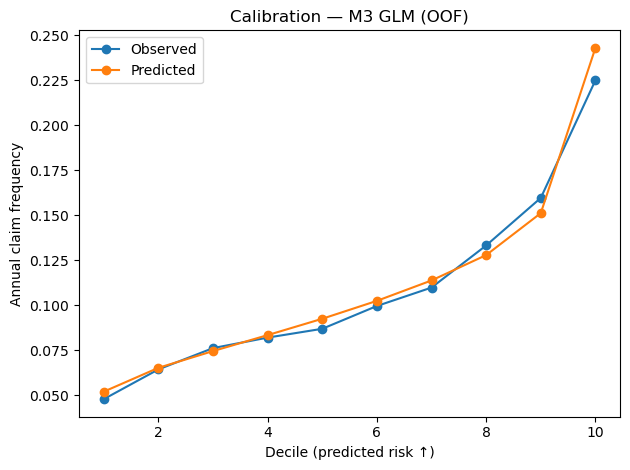

Mean metrics: {'fold': 2.0, 'overdispersion': 2.5715494918072355, 'poisson_dev': 0.35687934651177694, 'wMAE_rate': 0.18829553640175123, 'sMAPE_rate': 1.9799598249435502, 'top10_lift': 2.237963439172306}


In [11]:
M3_MAX_ITERS = 50        # IRLS cap for speed
M3_USE_NB_ONLY_IF_NEEDED = True

def fit_glm_offset(df):
    formula = (
        "ClaimNb ~ C(Area) + C(Region) + C(VehGas) + C(VehBrand) "
        "+ VehPower + VehAge + DrivAge + BonusMalus + np.log1p(Density)"
    )
    pois = smf.glm(
        formula=formula, data=df, family=sm.families.Poisson(),
        offset=np.log(df['Exposure'])
    ).fit(maxiter=M3_MAX_ITERS, disp=0)

    pearson_chi2 = ((df["ClaimNb"] - pois.mu)**2 / np.maximum(pois.mu, 1e-6)).sum()
    dispersion = float(pearson_chi2 / (len(df) - pois.df_model - 1))

    if M3_USE_NB_ONLY_IF_NEEDED and dispersion <= 1.8:
        return pois, "Poisson", dispersion

    nb = smf.glm(
        formula=formula, data=df,
        family=sm.families.NegativeBinomial(alpha=max(1e-6, dispersion-1)),
        offset=np.log(df['Exposure'])
    ).fit(maxiter=M3_MAX_ITERS, disp=0)

    return nb, "NegBin", dispersion

def cv_glm_offset(df, k=3, random_state=42):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error

    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    y = df["ClaimNb"].values
    exp = df["Exposure"].values

    oof_rate = np.zeros(len(df), dtype=float)
    rows = []
    for fold, (tr, va) in enumerate(kf.split(df), 1):
        dtr, dva = df.iloc[tr].copy(), df.iloc[va].copy()
        model, fam, disp = fit_glm_offset(dtr)
        mu = model.predict(dva, offset=np.log(dva["Exposure"]))  # counts
        p_rate = (mu / dva["Exposure"]).values.clip(min=1e-8)
        oof_rate[va] = p_rate

        rows.append({
            "fold": fold,
            "family": fam,
            "overdispersion": disp,
            "poisson_dev": w_poisson_deviance(dva["ClaimNb"].values, mu.values, dva["Exposure"].values),
            "wMAE_rate": mean_absolute_error((dva["ClaimNb"]/dva["Exposure"]).values, p_rate, sample_weight=dva["Exposure"].values),
            "sMAPE_rate": smape((dva["ClaimNb"]/dva["Exposure"]).values, p_rate, dva["Exposure"].values),
            "top10_lift": top_decile_lift(dva["ClaimNb"].values, p_rate, dva["Exposure"].values),
        })

    res = pd.DataFrame(rows); display(res)
    cal = decile_calibration_table(y, oof_rate, exp)
    plot_calibration(cal, "Calibration — M3 GLM (OOF)")
    summ = res.mean(numeric_only=True).to_dict()
    print("Mean metrics:", summ)
    return summ, oof_rate, cal, res

m3_summary, m3_oof_rate, m3_cal, m3_folds = cv_glm_offset(train_c, k=3)

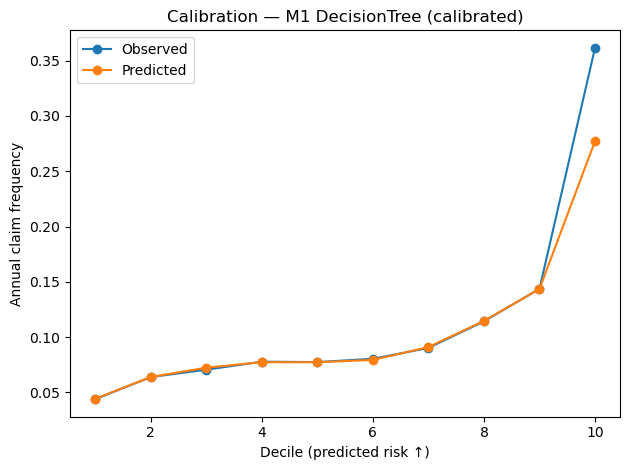

M1 DecisionTree calibrated -> dev=0.347194, wMAE=0.180027, top10_lift=3.596


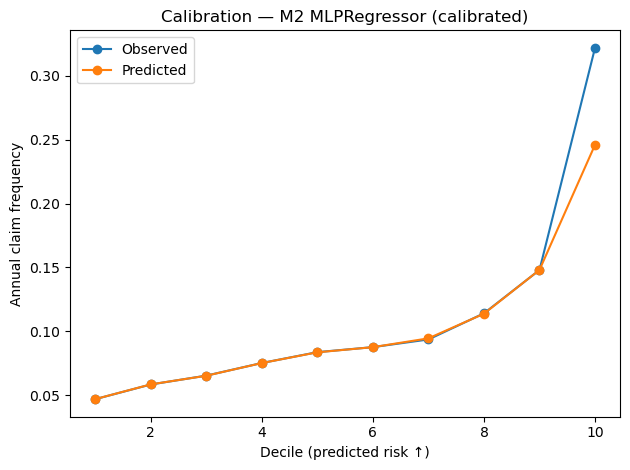

M2 MLPRegressor calibrated -> dev=0.350002, wMAE=0.180698, top10_lift=3.205


,model,poisson_dev,wMAE_rate,top10_lift,fold,overdispersion,sMAPE_rate
0,M1 DecisionTree (cal),0.347194,0.180027,3.595624,NaN,NaN,NaN
1,M2 MLPRegressor (cal),0.350002,0.180698,3.205323,NaN,NaN,NaN
2,M3 GLM offset,0.356879,0.188296,2.237963,2.0,2.571549,1.97996


Champion model: M1 DecisionTree (cal)
Test predictions (champion + references) — preview:


,IDpol,Exposure,pred_rate,pred_count,pred_rate_m1_cal,pred_rate_m2_cal,pred_rate_m3
0,1135885,1.00,0.077290,0.077290,0.077290,0.052651,0.087324
1,51280,0.24,0.113035,0.027128,0.113035,0.145515,0.099866
2,6112464,0.41,0.310822,0.127437,0.310822,0.286229,0.155152
3,3245787,0.07,0.077290,0.005410,0.077290,0.081156,0.084068
4,168150,0.06,0.077290,0.004637,0.077290,0.058144,0.067747


TEST metrics — Poisson dev=0.347898, wMAE_rate=0.180560, top10_lift=3.648


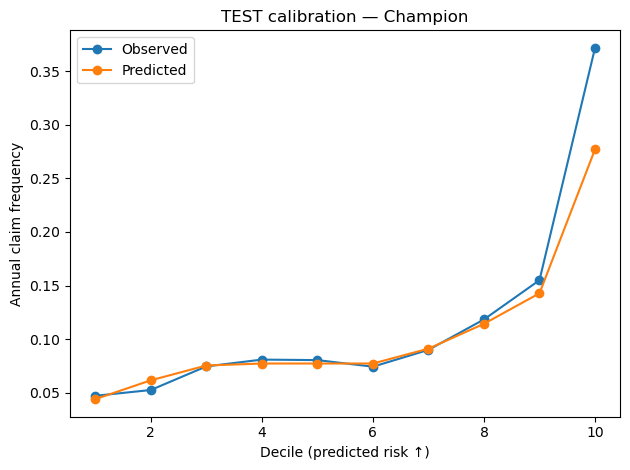

[Timing] Cell 12 completed in 57.9s


In [12]:
# === Cell 12 — Calibrate (M1/M2), compare with GLM, select champion, refit & predict ===
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

t0 = time.perf_counter()

# ---------------------------
# Safety: ensure core vars exist
# ---------------------------
if 'FEATURES' not in globals():
    FEATURES = ["Area","VehBrand","VehGas","Region","VehPower","VehAge","DrivAge","BonusMalus","Density"]
if 'X' not in globals():
    X = train_c[FEATURES].copy()
if 'y_rate' not in globals():
    train_c["y_rate"] = train_c["ClaimNb"] / train_c["Exposure"]
    y_rate = train_c["y_rate"].values
if 'w' not in globals():
    w = train_c["Exposure"].values

# ---- Fallbacks for metrics/plots if they aren't defined earlier ----
if 'w_poisson_deviance' not in globals():
    def w_poisson_deviance(y_true_count, mu_count, w_exposure=None, eps=1e-12):
        y  = np.asarray(y_true_count, float)
        mu = np.clip(np.asarray(mu_count, float), eps, None)
        if w_exposure is None:
            w_exposure = np.ones_like(y)
        term = np.where(y > 0, y*np.log((y+eps)/mu) - (y-mu), -(y-mu))
        return float(np.sum(2.0 * term * w_exposure) / np.sum(w_exposure))

if 'top_decile_lift' not in globals():
    def top_decile_lift(y_true_count, pred_rate, exposure, frac=0.10):
        y = np.asarray(y_true_count, float)
        p = np.asarray(pred_rate, float)
        e = np.asarray(exposure, float)
        k = max(1, int(np.ceil(frac * len(p))))
        idx = np.argsort(-p)[:k]
        rate_top = y[idx].sum() / e[idx].sum()
        rate_all = y.sum() / e.sum()
        return float(rate_top / rate_all) if rate_all > 0 else np.nan

if 'decile_calibration_table' not in globals():
    def decile_calibration_table(ycnt, prate, exp, n=10):
        df = pd.DataFrame({"y": ycnt, "p": prate, "w": exp})
        df = df.sort_values("p").reset_index(drop=True)
        df["decile"] = pd.qcut(df.index, q=n, labels=False) + 1
        tab = df.groupby("decile").apply(
            lambda g: pd.Series({
                "exposure": g["w"].sum(),
                "obs_freq": g["y"].sum() / g["w"].sum(),
                "pred_freq": (g["p"] * g["w"]).sum() / g["w"].sum()
            })
        ).reset_index()
        return tab

if 'plot_calibration' not in globals():
    def plot_calibration(tab, title):
        plt.figure()
        plt.plot(tab["decile"], tab["obs_freq"], marker="o", label="Observed")
        plt.plot(tab["decile"], tab["pred_freq"], marker="o", label="Predicted")
        plt.title(title); plt.xlabel("Decile (predicted risk ↑)"); plt.ylabel("Annual claim frequency")
        plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------
# OOF coercion (works with DataFrame or 1D/2D arrays)
# ---------------------------
def ensure_oof_frame(oof_like, label, y_rate_vec, exposure_vec):
    """
    Return DataFrame with columns: oof_rate, Exposure, ClaimNb.
    Accepts DataFrame or 1D/2D arrays; rebuilds if needed.
    """
    if isinstance(oof_like, pd.DataFrame):
        df = oof_like.copy()
    else:
        arr = np.asarray(oof_like)
        if arr.ndim == 1:
            df = pd.DataFrame({
                "oof_rate": arr,
                "Exposure": exposure_vec,
                "ClaimNb": y_rate_vec * exposure_vec
            })
        elif arr.ndim == 2:
            df = pd.DataFrame(arr)
            rename_map = {}
            if 0 in df and "oof_rate" not in df.columns: rename_map[0] = "oof_rate"
            if 1 in df and "Exposure" not in df.columns: rename_map[1] = "Exposure"
            if 2 in df and "ClaimNb" not in df.columns: rename_map[2] = "ClaimNb"
            if rename_map: df = df.rename(columns=rename_map)
        else:
            raise TypeError(f"{label} must be DataFrame or 1D/2D array, got {type(oof_like)}")

    if "oof_pred_rate" in df.columns and "oof_rate" not in df.columns:
        df = df.rename(columns={"oof_pred_rate": "oof_rate"})

    if "Exposure" not in df.columns:
        df["Exposure"] = exposure_vec
    if "ClaimNb" not in df.columns:
        df["ClaimNb"] = y_rate_vec * df["Exposure"].values

    for c in ["oof_rate","Exposure","ClaimNb"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["oof_rate","Exposure","ClaimNb"]).reset_index(drop=True)

    need = {"oof_rate","Exposure","ClaimNb"}
    missing = need - set(df.columns)
    if missing:
        raise RuntimeError(f"{label} missing columns {missing}. Needs {need}.")
    return df

m1_oof = ensure_oof_frame(m1_oof, "m1_oof", y_rate_vec=y_rate, exposure_vec=w)
m2_oof = ensure_oof_frame(m2_oof, "m2_oof", y_rate_vec=y_rate, exposure_vec=w)

# ---------------------------
# Isotonic calibrator (+ guardrail caps)
# ---------------------------
def fit_calibrator(oof_df):
    y_rate_true = (oof_df["ClaimNb"] / oof_df["Exposure"]).values
    x_pred      = oof_df["oof_rate"].values
    wexp        = oof_df["Exposure"].values

    x_pred = np.nan_to_num(x_pred, posinf=np.nanmax(x_pred[np.isfinite(x_pred)]) if np.isfinite(x_pred).any() else 1.0, neginf=0.0)
    x_pred = np.clip(x_pred, 0.0, None)

    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(x_pred, y_rate_true, sample_weight=wexp)

    port_rate = oof_df["ClaimNb"].sum() / oof_df["Exposure"].sum()
    cap = float(min(np.quantile(x_pred, 0.99), 3.0 * port_rate))
    return ir, cap, port_rate

def eval_calibrated(oof_df, ir, cap, name):
    x    = np.clip(oof_df["oof_rate"].values, 0.0, cap)
    wexp = oof_df["Exposure"].values
    ycnt = oof_df["ClaimNb"].values
    pred_rate = np.clip(ir.predict(x), 1e-8, None)

    dev  = w_poisson_deviance(ycnt, pred_rate * wexp, wexp)
    mae  = mean_absolute_error(ycnt / wexp, pred_rate, sample_weight=wexp)
    lift = top_decile_lift(ycnt, pred_rate, wexp)

    cal = decile_calibration_table(ycnt, pred_rate, wexp)
    plot_calibration(cal, f"Calibration — {name} (calibrated)")
    print(f"{name} calibrated -> dev={dev:.6f}, wMAE={mae:.6f}, top10_lift={lift:.3f}")
    return {"poisson_dev": dev, "wMAE_rate": mae, "top10_lift": lift}, pred_rate

# Fit + evaluate calibrators
m1_ir, m1_cap, m1_port = fit_calibrator(m1_oof)
m2_ir, m2_cap, m2_port = fit_calibrator(m2_oof)
m1_cal_metrics, m1_oof_rate_cal = eval_calibrated(m1_oof, m1_ir, m1_cap, "M1 DecisionTree")
m2_cal_metrics, m2_oof_rate_cal = eval_calibrated(m2_oof, m2_ir, m2_cap, "M2 MLPRegressor")

# ---------------------------
# GLM (robust to unseen levels like '_OTHER')
# ---------------------------
GLM_CAT_COLS = ["Area","Region","VehGas","VehBrand"]

def prepare_glm_frames_and_formula(train_df, test_df, other_label="_OTHER", missing_label="_MISSING_"):
    """Align categorical levels and build formula with explicit levels (Patsy-safe)."""
    tr = train_df.copy()
    te = test_df.copy()
    for c in GLM_CAT_COLS:
        tr[c] = tr[c].astype(str).fillna(missing_label)
        te[c] = te[c].astype(str).fillna(missing_label)
        seen = set(tr[c].unique())
        mask = ~te[c].isin(seen)
        if mask.any():
            te.loc[mask, c] = other_label

    def lvls(col):
        return sorted(list(set(tr[col].unique()) | set(te[col].unique()) | {other_label}))

    formula = (
        f"ClaimNb ~ "
        f"C(Area,    levels={repr(lvls('Area'))}) + "
        f"C(Region,  levels={repr(lvls('Region'))}) + "
        f"C(VehGas,  levels={repr(lvls('VehGas'))}) + "
        f"C(VehBrand,levels={repr(lvls('VehBrand'))}) + "
        "VehPower + VehAge + DrivAge + BonusMalus + np.log1p(Density)"
    )
    return tr, te, formula

def fit_glm_offset_with_formula(df, formula, max_iters=50, use_nb_if_needed=True):
    m_pois = smf.glm(
        formula=formula, data=df, family=sm.families.Poisson(),
        offset=np.log(df["Exposure"])
    ).fit(maxiter=max_iters, disp=0)

    pearson_chi2 = ((df["ClaimNb"] - m_pois.mu)**2 / np.maximum(m_pois.mu, 1e-6)).sum()
    dispersion = float(pearson_chi2 / (len(df) - m_pois.df_model - 1))

    if use_nb_if_needed and dispersion > 1.8:
        m_nb = smf.glm(
            formula=formula, data=df,
            family=sm.families.NegativeBinomial(alpha=max(1e-6, dispersion-1)),
            offset=np.log(df["Exposure"])
        ).fit(maxiter=max_iters, disp=0)
        return m_nb, "NegBin", dispersion
    return m_pois, "Poisson", dispersion

# Prepare aligned frames + formula and fit GLM on full train
train_glm, test_glm, glm_formula = prepare_glm_frames_and_formula(train_c, test_c)
m3_full, m3_family, m3_disp = fit_glm_offset_with_formula(train_glm, glm_formula)

# Predict GLM on aligned test (counts -> rate)
mu_m3   = m3_full.predict(test_glm, offset=np.log(test_glm["Exposure"]))
pred_m3 = np.clip((mu_m3 / test_glm["Exposure"]).values, 1e-8, None)

# ---------------------------
# Compare calibrated M1/M2 vs GLM (by OOF metrics) and select champion
# ---------------------------
rows = [
    {"model": "M1 DecisionTree (cal)", **m1_cal_metrics},
    {"model": "M2 MLPRegressor (cal)", **m2_cal_metrics},
]
if 'm3_summary' in globals() and isinstance(m3_summary, dict) and 'poisson_dev' in m3_summary:
    rows.append({"model": "M3 GLM offset", **m3_summary})
comp = pd.DataFrame(rows).sort_values("poisson_dev")
display(comp)

champion = comp.iloc[0]["model"]
print("Champion model:", champion)

# ---------------------------
# Refit full M1/M2 and predict test, then apply calibrators
# ---------------------------
m1_pipe = make_m1().fit(X, y_rate, **{"model__sample_weight": w})
m2_pipe = make_m2().fit(X, y_rate, **{"model__sample_weight": w})

X_test = test_c[FEATURES]
pred_m1_raw = np.clip(m1_pipe.predict(X_test), 1e-8, None)
pred_m2_raw = np.clip(m2_pipe.predict(X_test), 1e-8, None)
pred_m1_cal = np.clip(m1_ir.predict(np.clip(pred_m1_raw, 0.0, m1_cap)), 1e-8, None)
pred_m2_cal = np.clip(m2_ir.predict(np.clip(pred_m2_raw, 0.0, m2_cap)), 1e-8, None)

# Choose champion prediction vector
if champion.startswith("M1"):
    pred_rate = pred_m1_cal
elif champion.startswith("M2"):
    pred_rate = pred_m2_cal
else:
    pred_rate = pred_m3  # GLM

# ---------------------------
# Output (and optional test scoring if labels exist)
# ---------------------------
out = pd.DataFrame({
    ID_COL: test_c[ID_COL].values,
    "Exposure": test_c["Exposure"].values,
    "pred_rate": pred_rate,
    "pred_count": pred_rate * test_c["Exposure"].values,
    "pred_rate_m1_cal": pred_m1_cal,
    "pred_rate_m2_cal": pred_m2_cal,
    "pred_rate_m3": pred_m3
})
print("Test predictions (champion + references) — preview:")
display(out.head())

# If the test set contains ClaimNb, compute test metrics & calibration
if "ClaimNb" in test_c.columns:
    joined = out[[ID_COL,"pred_rate"]].merge(test_c[[ID_COL,"ClaimNb","Exposure"]], on=ID_COL, how="left")
    dev  = w_poisson_deviance(joined["ClaimNb"].values,
                              joined["pred_rate"].values * joined["Exposure"].values,
                              joined["Exposure"].values)
    mae  = mean_absolute_error(joined["ClaimNb"].values / joined["Exposure"].values,
                               joined["pred_rate"].values,
                               sample_weight=joined["Exposure"].values)
    lift = top_decile_lift(joined["ClaimNb"].values, joined["pred_rate"].values, joined["Exposure"].values)
    print(f"TEST metrics — Poisson dev={dev:.6f}, wMAE_rate={mae:.6f}, top10_lift={lift:.3f}")
    cal = decile_calibration_table(joined["ClaimNb"].values, joined["pred_rate"].values, joined["Exposure"].values)
    plot_calibration(cal, "TEST calibration — Champion")

print(f"[Timing] Cell 12 completed in {time.perf_counter()-t0:.1f}s")
